In [2]:
import numpy as np
import scipy
from scipy.linalg import expm
import random
import math
import cmath as cm
from scipy.stats import unitary_group
from scipy import linalg
import matplotlib.pyplot as plt
from scipy.optimize import minimize, curve_fit, basinhopping
import matplotlib
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.autograd.functional import jacobian, hessian
# import lightning as L
# from lightning.pytorch.loggers import TensorBoardLogger
import torch_optimizer

import os
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter

import torch

pi = np.pi

In [3]:
def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    


set_random_seed(42)

In [5]:
# import matplotlib.pyplot as plt
# import numpy as np
# import imageio.v2 as imageio  # `imageio.v2` avoids deprecation warnings
# import os

# # Create a folder for temporary images
# os.makedirs("frames", exist_ok=True)

# # Sweep over a parameter: frequency in a sine wave
# frames = []
# x = np.linspace(0, 2 * np.pi, 200)

# for i, freq in enumerate(np.linspace(1, 5, 20)):
#     y = np.sin(freq * x)

#     plt.figure(figsize=(5, 3))
#     plt.plot(x, y, label=f'freq = {freq:.2f}')
#     plt.ylim(-1.1, 1.1)
#     plt.legend()
#     plt.title("Sweeping Frequency")
    
#     filename = f'frames/frame_{i:03d}.png'
#     plt.savefig(filename)
#     plt.close()
#     frames.append(imageio.imread(filename))

# # Save as GIF
# imageio.mimsave('sine_sweep.gif', frames, duration=0.2)

# # Clean up frames if you want
# import shutil
# shutil.rmtree("frames")


In [6]:
torch.cuda.is_available()

True

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [8]:
"""Функция для хранения логов в TensorBoard и создания директорий для экспериментов."""

def make_log_dir(base_log_dir, exp_name):
    # Ensure base and experiment directories exist and make them if not
    os.makedirs(base_log_dir, exist_ok=True)

    exp_dir = os.path.join(base_log_dir, exp_name)
    os.makedirs(exp_dir, exist_ok=True)

    # Find the next version number
    version_num = 0
    for dirname in os.listdir(exp_dir):
        try:
            version_num = max(version_num, int(dirname.split("_")[-1]) + 1)
        except ValueError:
            continue

    # Create the new version directory
    version_dir = os.path.join(exp_dir, f"version_{version_num}")
    os.makedirs(version_dir)

    return version_dir

In [9]:
def atan2f(y, x, tolerance=torch.tensor(1e-6), to_degree=False):
    zero_y = torch.abs(y) <= tolerance
    zero_x = torch.abs(x) <= tolerance
    if zero_x and zero_y:
        rad = 0
    elif zero_x and (not zero_y):
        rad = torch.pi/2 if y > tolerance else -torch.pi/2
    elif (not zero_x) and zero_y:
        rad = 0 if x > tolerance else torch.pi
    else:
        rad = torch.arctan2(y, x)
    if to_degree:
        return torch.rad2deg(rad)
    else:
        return rad
    

def angle_diff(comp_src, comp_dst, offset=0, tolerance=torch.tensor(1e-6), wrap=True, to_degree=False):
    zero_src = torch.abs(comp_src) <= tolerance
    zero_dst = torch.abs(comp_dst) <= tolerance
    if zero_src and zero_dst:
        rad = 0
    elif zero_src and (not zero_dst):
        rad = torch.angle(comp_dst)
    elif (not zero_src) and zero_dst:
        rad = -torch.angle(comp_src)
    else:
        rad = torch.angle(comp_dst) - torch.angle(comp_src)
    rad += offset
    if wrap:
        rad = torch.remainder(rad, 2 * torch.pi)
    if to_degree:
        return torch.rad2deg(rad)
    else:
        return rad
    
def get_angles(N, v):
    return v[:N*(N-1)//2], v[N*(N-1)//2:2*N*(N-1)//2], v[2*N*(N-1)//2:2*N*(N-1)//2 + N]

In [10]:
def U2MZI(dim, m, n, phi, theta, Lp=torch.tensor(1), Lc=torch.tensor(1), device='cuda'):
    assert m < n < dim
    mat = torch.eye(dim, dtype=torch.complex128, device=device)
    mat[m, m] = torch.sqrt(Lp) * 1j * torch.exp(1j * phi) * torch.sin(theta)
    mat[m, n] = torch.sqrt(Lc) * 1j * torch.cos(theta)
    mat[n, m] = torch.sqrt(Lc) * 1j * torch.exp(1j * phi) * torch.cos(theta)
    mat[n, n] = -torch.sqrt(Lp) * 1j * torch.sin(theta)
    return mat

def decompose_reck(u, block='bs', device='cuda'):
    assert isinstance(u, torch.Tensor)
    assert isinstance(block, str) and block.strip().lower() in ['bs', 'mzi']
    if len(u.shape) != 2:
        raise ValueError("U(N) should be 2-dimension matrix.")
        
    if u.shape[0] != u.shape[1]:
        raise ValueError("U(N) should be a square matrix.")
        
    mat = u.clone().to(torch.complex128)
    dim = mat.shape[0]
    num = int(dim * (dim - 1) / 2)
    phis = torch.zeros(num, device=device)
    thetas = torch.zeros(num, device=device)
    alphas = torch.zeros(dim, device=device)
    index = 0
    for p in range(1, dim):
        x = dim - p
        for q in range(dim-p, 0, -1):
            y = q - 1
            if block == 'bs':
                thetas[index] = atan2f(torch.abs(mat[x,y]), torch.abs(mat[x,x]))
                phis[index] = angle_diff(mat[x,x], mat[x,y], offset=-np.pi/2)
                U2block = U2BS
            elif block == 'mzi':
                thetas[index] = np.pi/2 - atan2f(torch.abs(mat[x,y]), torch.abs(mat[x,x]))
                phis[index] = angle_diff(mat[x,x], mat[x,y], offset=np.pi)
                U2block = U2MZI
            mat = mat @ U2block(dim, y, x, phis[index], thetas[index]).conj().T
            index += 1
    for i in range(dim):
        alphas[i] = torch.angle(mat[i, i])
    return phis, thetas, alphas

def reconstruct_reck(phis, thetas, alphas, block='bs', Lp_dB=0, Lc_dB=0, device='cuda'):
    assert len(phis.squeeze().shape) == 1
    assert len(thetas.squeeze().shape) == 1
    assert len(alphas.squeeze().shape) == 1
    assert phis.squeeze().shape[0] == thetas.squeeze().shape[0]
    assert isinstance(block, str) and block.strip().lower() in ['bs', 'mzi']
    if block == 'bs':
        U2block = U2BS
    elif block == 'mzi':
        U2block = U2MZI
    
    num = thetas.squeeze().shape[0]
    dim = int((1 + np.sqrt(1 + 8 * num))/ 2)
    assert alphas.squeeze().shape[0] == dim
    
    Lp = torch.tensor(10 ** (Lp_dB / 10), device=device)
    Lc = torch.tensor(10 ** (Lc_dB / 10), device=device)
    
    mat = torch.diag(torch.exp(1j * alphas)).to(torch.complex128)
    index = num
    for p in range(1, dim):
        for q in range(p):
            index -= 1
            mat = mat @ U2block(dim, q, p, phis[index], thetas[index], Lp=Lp, Lc=Lc)
    return mat

In [11]:
def Haar_Random_U(n):
    """A Random matrix distributed with Haar measure"""
    z = (np.random.randn(n, n) + 1j * np.random.randn(n, n)) / math.sqrt(2.0)
    q, r = linalg.qr(z)
    d = np.diagonal(r)
    ph = d / abs(d)
    q = np.multiply(q, ph, q)
    return q

def Haar_Random_U_torch(n, device):
    """A Random matrix distributed with Haar measure"""
    z = (np.random.randn(n, n) + 1j * np.random.randn(n, n)) / math.sqrt(2.0)
    q, r = linalg.qr(z)
    d = np.diagonal(r)
    ph = d / abs(d)
    q = np.multiply(q, ph, q)
    return torch.from_numpy(q).to(dtype=torch.complex128, device=device)

def Is_unitary(m):
    return np.allclose(np.eye(m.shape[0]), m.H * m)

def Is_unitary_torch(m, device='cuda'):
    return torch.allclose(torch.eye(m.shape[0],dtype=torch.complex128, device=device), m.mH @ m)

In [12]:
N=4
U_true = Haar_Random_U_torch(N, device=device)
print("U_true:\n", U_true)
[p, t, a] = decompose_reck(U_true, block='mzi')
print(f'Reck[MZI] Decomposition:\n\tphis: {p}\n\tthetas: {t}\n\talphas: {a}')
reck_test = reconstruct_reck(p, t, a, block='mzi')
print(f'Reck[MZI] Reconstructed:\n{reck_test}')
print(f'Reck[MZI] Test:\t\t {torch.allclose(reck_test, U_true)}')

U_true:
 tensor([[ 0.2365-0.4822j,  0.0683+0.0445j,  0.5115-0.0953j,  0.5521-0.3597j],
        [-0.1115+0.6978j, -0.2494+0.0841j,  0.4671-0.4319j,  0.1622-0.0182j],
        [-0.2235-0.2592j,  0.2436-0.0538j, -0.0926-0.5381j,  0.2727+0.6694j],
        [ 0.1152-0.2860j, -0.9016-0.2210j, -0.0963-0.1311j, -0.0200+0.1277j]],
       device='cuda:0', dtype=torch.complex128)
Reck[MZI] Decomposition:
	phis: tensor([5.4941, 3.2264, 3.3690, 5.8161, 1.6602, 0.1199], device='cuda:0')
	thetas: tensor([0.6715, 0.2201, 1.2574, 0.5395, 1.2028, 0.6499], device='cuda:0')
	alphas: tensor([ 1.5901, -1.8490,  2.1132,  0.1555], device='cuda:0')
Reck[MZI] Reconstructed:
tensor([[ 0.2365-0.4822j,  0.0683+0.0445j,  0.5115-0.0953j,  0.5521-0.3597j],
        [-0.1115+0.6978j, -0.2494+0.0841j,  0.4671-0.4319j,  0.1622-0.0182j],
        [-0.2235-0.2592j,  0.2436-0.0538j, -0.0926-0.5381j,  0.2727+0.6694j],
        [ 0.1152-0.2860j, -0.9016-0.2210j, -0.0963-0.1311j, -0.0200+0.1277j]],
       device='cuda:0', dtype=to

In [13]:
data = []
data_no_current = []
for ch in range(4):
    for H in range(3):
        with open(f"Calibration Example_915\ch{ch + 1}_H{H + 1}.txt") as file:
            for line in file:
                try:
                    row = [float(num) for num in line.split()]
                    if row[0] % 40 == 0:
                        data.append([ch,H] + row)
                    else:
                        continue
                    if row[0] == 0:
                        data_no_current.append([ch,H] + row)
                except:
                    pass

def f(v, data=data, device='cuda', current_coefficient=np.sqrt(0.5*10**(-5))):
    p1, t1, a1 = get_angles(4, v[:16])
    p2, t2, a2 = get_angles(4, v[16:32])
    M1 = reconstruct_reck(p1, t1, a1, block='mzi')
    M2 = reconstruct_reck(p2, t2, a2, block='mzi')
    alpha = v[32:41].reshape(3, 3)
    h_0 = v[41:44]
    # current_coefficient = np.sqrt(0.5*10**(-5))
    cost = 0

    for i in data:
        x = torch.zeros(3, dtype=torch.float64, device=device)
        x[i[1]] = current_coefficient * i[2] ** 2
        y = torch.tensor(i[3:], dtype=torch.complex128, device=device)
        y /= torch.sum(y)
        
        h_list = h_0 + alpha @ x
        h_list = h_list%(2 * np.pi)
        H_diag = torch.cat([
            torch.exp(1j * h_list),
            torch.tensor([1.0], dtype=torch.complex128, device=device)
        ])
        H = torch.diag(H_diag)
        predict = (M2 @ H @ M1).T
        predict_abs_sq = torch.sqrt(predict.real**2 + predict.imag**2)
        cost += torch.norm(predict_abs_sq[i[0]] - y)
    return cost

def clement_reconstruction(v, U):
    p, t, a = get_angles(4, v)
    reck = reconstruct_reck(p, t, a, block='mzi')
    return torch.norm(reck - U)

def clement_reconstruction_2(v, U):
    p1, t1, a1 = get_angles(4, v[:16])
    p2, t2, a2 = get_angles(4, v[16:32])
    reck1 = reconstruct_reck(p1, t1, a1, block='mzi')
    reck2 = reconstruct_reck(p2, t2, a2, block='mzi')
    return torch.norm(reck1 @ reck2 - U)

In [14]:
def f_hessian(x, f):
    x0_torch = torch.from_numpy(x).to(device)
    x0_torch.requires_grad = True
    x0_torch = x0_torch.double()
    H = hessian(f, x0_torch)
    return H.to('cpu').numpy()

def f_jacobian(x, f):
    x0_torch = torch.from_numpy(x).to(device)
    x0_torch.requires_grad = True
    x0_torch = x0_torch.double()
    J = jacobian(f, x0_torch)
    return J.to('cpu').numpy()

In [15]:
seed = 42
torch.manual_seed(seed)
if device == "cuda":
    torch.cuda.manual_seed(seed)

x0 = nn.Parameter(torch.randn(44, dtype=torch.float64, device=device), requires_grad=True)
optimizer =  torch.optim.LBFGS([x0], lr=0.01)#optim.Adam([x0])
# scheduler = CosineAnnealingLR(optimizer, T_max=100, eta_min=0.001)
print(x0)

Parameter containing:
tensor([ 1.0360, -1.9756, -1.0678, -0.7353,  0.7025, -0.9603, -0.9174,  0.4056,
         0.8095, -0.4858,  0.7850, -0.2401, -0.6946, -1.9525,  0.3928, -1.0636,
         0.2125, -1.6480, -0.5147,  1.1583,  0.3495,  0.7480, -0.5551,  0.8343,
         1.0950,  0.2491, -1.0698,  0.0790, -0.0837,  0.0323,  0.5160, -0.6834,
         1.0061,  0.5087, -1.2080,  1.3042,  0.4475, -1.2036,  2.0147, -0.4452,
        -1.6052, -0.8079, -0.3307,  0.1415], device='cuda:0',
       dtype=torch.float64, requires_grad=True)


In [ ]:
from torch.utils.tensorboard import SummaryWriter

x0 = nn.Parameter(torch.randn(16, dtype=torch.float64, device=device), requires_grad=True)
optimizer =  torch.optim.LBFGS([x0], lr=0.01)

steps = 30

seed = 42
torch.manual_seed(seed)
if device == "cuda":
    torch.cuda.manual_seed(seed)

def make_closure(current_coefficient):
    def closure():
        optimizer.zero_grad()
        loss = clement_reconstruction(x0, U_true)
        loss.backward(create_graph=True)
        print(f"loss: {loss.item()}")
        if loss.item() < 1e-4:
            print("Converged")

        return loss
    return closure


# run_id = datetime.now().strftime("test")
# log_dir = os.path.join("logs", "clements-recon", run_id)
# writer = SummaryWriter(log_dir=log_dir)

closure = make_closure(0.001)

for n in range(steps):
    print(f"Step {n + 1}/{steps}")
    optimizer.step(closure)
    # scheduler.step()
    print(x0.grad)

In [14]:
print(reconstruct_reck(*get_angles(N, x0[:16]), block='mzi'))
print(U_true)

tensor([[ 0.2365-0.4823j,  0.0682+0.0446j,  0.5115-0.0953j,  0.5521-0.3597j],
        [-0.1115+0.6978j, -0.2495+0.0842j,  0.4670-0.4319j,  0.1622-0.0182j],
        [-0.2235-0.2592j,  0.2435-0.0538j, -0.0926-0.5381j,  0.2727+0.6695j],
        [ 0.1152-0.2860j, -0.9017-0.2210j, -0.0964-0.1311j, -0.0202+0.1275j]],
       device='cuda:0', dtype=torch.complex128, grad_fn=<MmBackward0>)
tensor([[ 0.2365-0.4822j,  0.0683+0.0445j,  0.5115-0.0953j,  0.5521-0.3597j],
        [-0.1115+0.6978j, -0.2494+0.0841j,  0.4671-0.4319j,  0.1622-0.0182j],
        [-0.2235-0.2592j,  0.2436-0.0538j, -0.0926-0.5381j,  0.2727+0.6694j],
        [ 0.1152-0.2860j, -0.9016-0.2210j, -0.0963-0.1311j, -0.0200+0.1277j]],
       device='cuda:0', dtype=torch.complex128)


In [ ]:
from torch.utils.tensorboard import SummaryWriter

min_loss = 1e10
steps = 10

seed = 42
torch.manual_seed(seed)
if device == "cuda":
    torch.cuda.manual_seed(seed)

def make_closure(current_coefficient):
    def closure():
        optimizer.zero_grad()
        loss = f(x0, data=data, device=device, current_coefficient=current_coefficient)
        loss.backward(create_graph=True)
        print(f"loss: {loss.item()}")
        if loss.item() < 1e-4:
            print("Converged")

        return loss
    return closure


base_log_dir = "logs"
exp_name = "clements-graph"
version_dir = make_log_dir(base_log_dir, exp_name)
print(f"Logging process into {version_dir}")
writer = SummaryWriter(version_dir)

closure = make_closure(0.001)

for n in range(steps):
    print(f"Step {n + 1}/{steps}")
    optimizer.step(closure)
    # scheduler.step()
    print(x0.grad)

In [16]:
base_log_dir = "logs"
exp_name = "clements-graph"
version_dir = make_log_dir(base_log_dir, exp_name)
print(f"Logging process into {version_dir}")
writer = SummaryWriter(version_dir)
loss
writer.add_scalar("Loss", epoch)

writer.flush()

writer.close()

Logging process into logs\clements-graph\version_0


NameError: name 'loss' is not defined

In [46]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir logs/clements-graph/ --port 8001

In [49]:
def get_last_version_log_path(base_log_dir, exp_name):

    def extract_integer(path):
        return int(path.split(".")[0].split("_")[1])

    exp_dir = os.path.join(base_log_dir, exp_name)
    last_version = sorted(os.listdir(exp_dir), key=extract_integer)[-1]

    log_path = os.path.join(exp_dir, last_version)
    return log_path

base_log_dir = "logs"
exp_name = "clements-graph"
log_path = get_last_version_log_path(base_log_dir, exp_name)

print(f"Reading logs from {log_path}")

Reading logs from logs\clements-graph\version_0


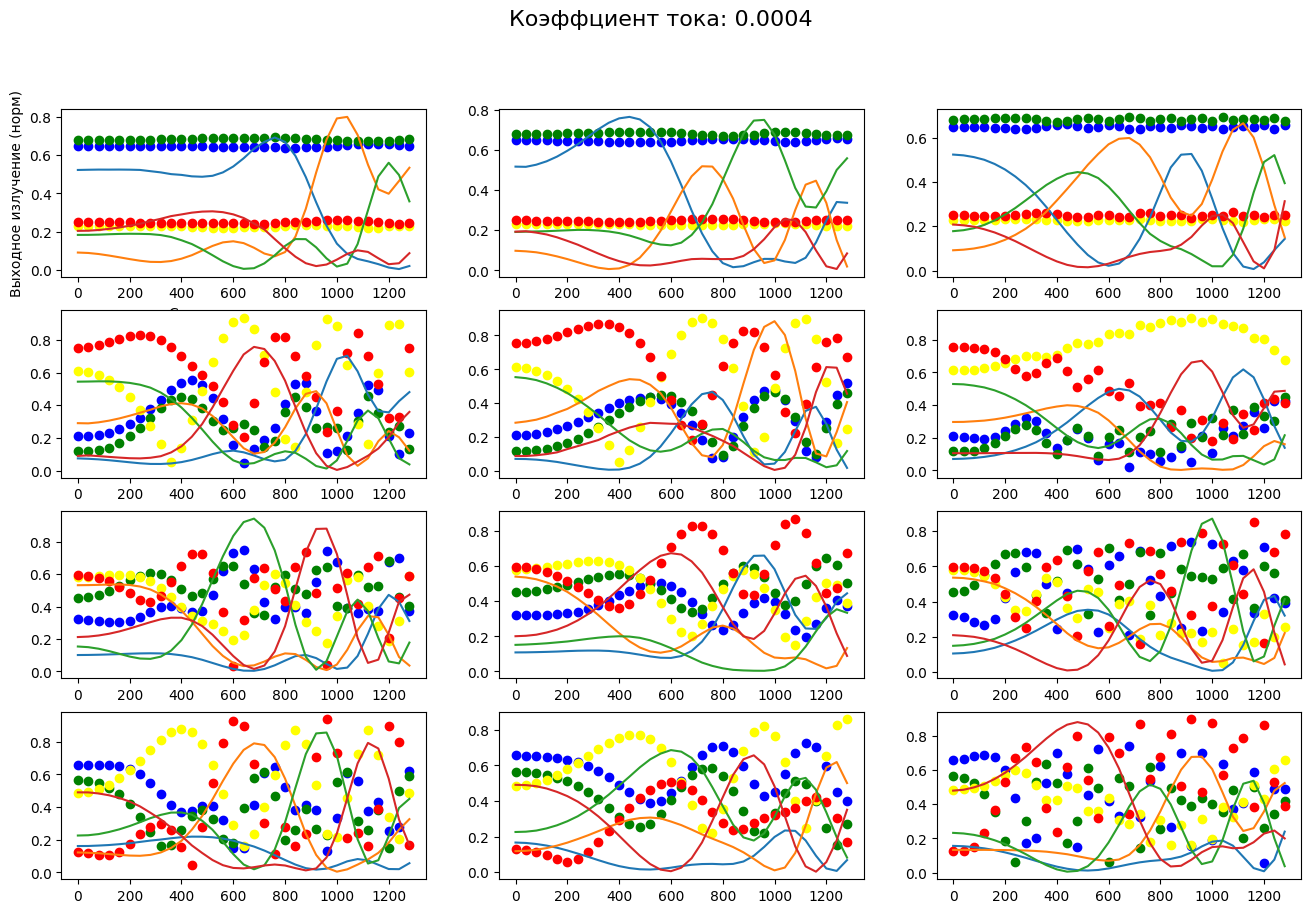

In [17]:
x0_fit = torch.randn(42, dtype=torch.float32, device=device)*100

M1 =  reconstruct_reck(*get_angles(4, x0_fit[:16]), block='mzi')
M2 =  reconstruct_reck(*get_angles(4, x0_fit[16:32]), block='mzi')
alpha = torch.reshape(x0_fit[32:41], (3, 3))
h_0 = x0_fit[41:44].to(device=device, dtype=torch.complex128)

current_coefficient = 0.0004
fig, ax = plt.subplots(4, 3, figsize=(16, 10))

for j in range(4):
    for k in range(3):

        # for i in data[131*(3*j+k):131*(3*j+k+1)]:
        for i in data[33*(3*j+k):33*(3*j+k+1)]:
            # x = torch.zeros(3, dtype=torch.complex128, device=device)
            # x[i[1]] = (current_coefficient * i[2]) ** 2
            # y = torch.tensor(i[3:], dtype=torch.complex128, device=device)
            # y /= torch.sum(y)

            # h_list = h_0 + alpha @ x
            # H_diag = torch.cat([torch.exp(1j * h_list), torch.tensor([1.0], dtype=torch.complex64, device=device)])
            # H = torch.diag(H_diag)
            # result_plot = (torch.abs((M2 @ H @ M1).T) ** 2)[i[0]]
            # ax[j][k].scatter(i[2], result_plot[0].cpu().detach().numpy(), color = 'blue')
            # ax[j][k].scatter(i[2], result_plot[1].cpu().detach().numpy(), color = 'green')
            # ax[j][k].scatter(i[2], result_plot[2].cpu().detach().numpy(), color = 'yellow')
            # ax[j][k].scatter(i[2], result_plot[3].cpu().detach().numpy(), color = 'red')

            x = torch.zeros(3).to(device=device)
            x[i[1]] = (current_coefficient * i[2]) ** 2
            y = torch.tensor(i[3:], dtype=torch.complex64, device=device)
            y /= torch.sum(y)

            h_list = h_0 + alpha @ x
            H_diag = torch.cat([torch.exp(1j * h_list), torch.tensor([1.0], dtype=torch.complex64, device=device)])
            H = torch.diag(H_diag)
            predict = (M2 @ H @ M1).T
            result_plot = torch.sqrt((predict.real**2 + predict.imag**2))[i[0]]
            # (torch.abs((M2 @ H @ M1).T) ** 2)[i[0]]
            ax[j][k].scatter(i[2], result_plot[0].cpu().detach().numpy(), color = 'blue')
            ax[j][k].scatter(i[2], result_plot[1].cpu().detach().numpy(), color = 'green')
            ax[j][k].scatter(i[2], result_plot[2].cpu().detach().numpy(), color = 'yellow')
            ax[j][k].scatter(i[2], result_plot[3].cpu().detach().numpy(), color = 'red')

        ax[j][k].plot([d[2] for d in data[33*(3*j+k):33*(3*j+k+1)]], [d[3]/sum(d[3:]) for d in data[33*(3*j+k):33*(3*j+k+1)]])#, color = 'blue')
        ax[j][k].plot([d[2] for d in data[33*(3*j+k):33*(3*j+k+1)]], [d[4]/sum(d[3:]) for d in data[33*(3*j+k):33*(3*j+k+1)]])#, color = 'green')
        ax[j][k].plot([d[2] for d in data[33*(3*j+k):33*(3*j+k+1)]], [d[5]/sum(d[3:]) for d in data[33*(3*j+k):33*(3*j+k+1)]])#, color = 'yellow')
        ax[j][k].plot([d[2] for d in data[33*(3*j+k):33*(3*j+k+1)]], [d[6]/sum(d[3:]) for d in data[33*(3*j+k):33*(3*j+k+1)]])#, color = 'red')

        ax[0][0].set_xlabel('Сила тока, единицы')
        ax[0][0].set_ylabel('Выходное излучение (норм)')

        fig.suptitle('Фитирование данных Ильи с помощью нашего кода')
        fig.suptitle('Коэффциент тока: ' + str(current_coefficient), fontsize=16)


plt.show()